In this notebook we will be working on the Commonlit Evaluate Student Summaries dataset.

*HW1 is Practice 1 section and HW2 is Practice 2 section*

# **Practice 1**

## **Importing Libraries**

In [82]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [83]:
%matplotlib inline

In [84]:
warnings.filterwarnings('ignore')

The next cell will install kaggle which soon will allow us to download the dataset

In [85]:
!pip install kaggle

In the following cell, upload the kaggle.json API file which will let us download the dataset

[How to create kaggle.json API file](https://www.kaggle.com/docs/api)

In [86]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geraygench","key":"044426052610aea6df5ef6aaaa85b3ce"}'}

In [87]:
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [88]:
! kaggle competitions download -c commonlit-evaluate-student-summaries

commonlit-evaluate-student-summaries.zip: Skipping, found more recently modified local copy (use --force to force download)


In [89]:
import zipfile
import os

# Specify the path to the zip archive
zip_file_path = 'commonlit-evaluate-student-summaries.zip'

# Specify the directory where you want to extract the files
extract_dir = 'commonlit_evaluate_student_summaries'

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

print("Zip archive extracted to", extract_dir)

Zip archive extracted to commonlit_evaluate_student_summaries


## Dataset Description

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording.

### File and Field Information

* summaries_train.csv - Summaries in the training set.
 * student_id - The ID of the student writer.
 * prompt_id - The ID of the prompt which links to the prompt file.
 * text - The full text of the student's summary.
 * content - The content score for the summary. The first target.
 * wording - The wording score for the summary. The second target.
* summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.
* prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 * prompt_id - The ID of the prompt which links to the summaries file.
 * prompt_question - The specific question the students are asked to respond to.
 * prompt_title - A short-hand title for the prompt.
 * prompt_text - The full prompt text.
* prompts_test.csv - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.
*sample_submission.csv - A submission file in the correct format

In [90]:
# This is how a sample submission looks
df_samplesub=pd.read_csv("commonlit_evaluate_student_summaries/sample_submission.csv")
df_samplesub.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [91]:
df_train_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_train.csv")
print("Shape of df_train_text: ",df_train_summ.shape)
df_train_summ.head()

Shape of df_train_text:  (7165, 5)


student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [92]:
df_train_summ.describe()

content      wording
count  7165.000000  7165.000000
mean     -0.014853    -0.063072
std       1.043569     1.036048
min      -1.729859    -1.962614
25%      -0.799545    -0.872720
50%      -0.093814    -0.081769
75%       0.499660     0.503833
max       3.900326     4.310693

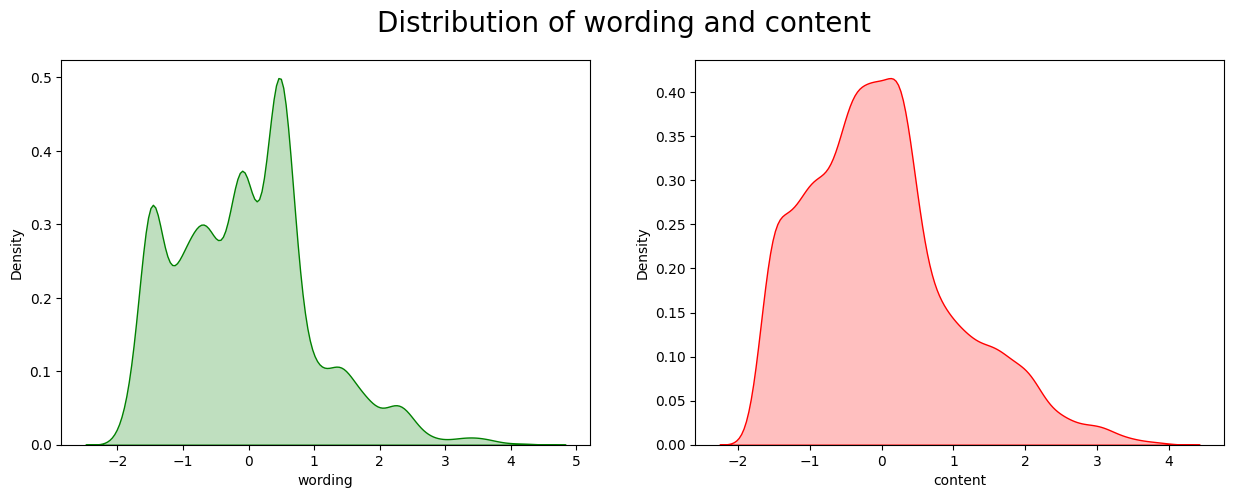

In [93]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Distribution of wording and content", fontsize=20)
sns.kdeplot(df_train_summ['wording'], shade=True, ax=ax[0], color='green')
sns.kdeplot(df_train_summ['content'], shade=True, ax=ax[1], color='red')
fig.show()


In [94]:
df_train_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_train.csv")
print("Shape of df_test_p: ",df_train_prompts.shape)
df_train_prompts.head(1)

Shape of df_test_p:  (4, 4)


prompt_id                                    prompt_question prompt_title  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...

In [95]:
df_test_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_test.csv")
print("Shape of df_test_text: ",df_test_summ.shape)
df_test_summ.head()

Shape of df_test_text:  (4, 3)


student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [96]:
df_test_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_test.csv")
print("Shape of df_test_p: ",df_test_prompts.shape)
df_test_prompts.head()

Shape of df_test_p:  (2, 4)


prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [97]:
! pip install ydata-profiling


Lets have a look at the dataset with the help of Profiling Report which tells us a lot about our dataset its structure and data type of each column




In [98]:
from ydata_profiling import ProfileReport

In [99]:
profile = ProfileReport(df_train_summ, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

([<matplotlib.patches.Wedge at 0x7d7f742007f0>,
 [Text(0.7441258598778328, 0.9414227024355617, '39c16e'),
  Text(-0.9871770139847208, 0.4852644053093227, '3b9047'),
  Text(-0.2951302904781698, -1.0596688688653033, 'ebad26'),
  Text(0.9738464548017034, -0.511491038504248, '814d6b')],
 [Text(0.434073418262069, 0.5491632430874109, '28.7%'),
  Text(-0.5384601894462113, 0.2646896756232669, '28.0%'),
  Text(-0.16098015844263805, -0.5780012011992562, '27.9%'),
  Text(0.5311889753463837, -0.27899511191140797, '15.4%')])

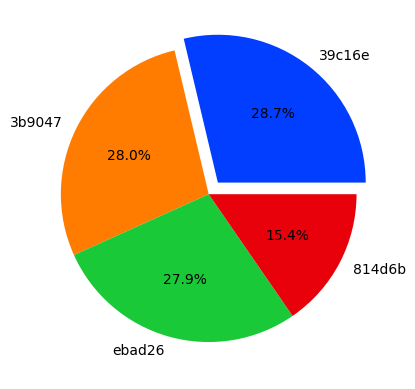

In [100]:
# Lets plot a pie of texts with different catagories of prompts

# explode offset for biggest slice
explode = (0.1, 0, 0, 0)
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
# plotting data on chart
plt.pie(df_train_summ['prompt_id'].value_counts(), labels=df_train_summ['prompt_id'].value_counts().index, colors=palette_color, autopct='%1.1f%%', explode=explode)

With Profiling Report and a pie chart we can see that the most used propt_id is 39c16e. Lets have a deep look at the values in the text using this prompt.

In [101]:
text = ' '.join(df_train_summ[df_train_summ['prompt_id']=='39c16e'].text.values)

First 1000 characters of the text

In [102]:
text[:1000]

'1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad. The three elements of an ideal tragedy are:  Having a character that isn\'t bad have misfortune befall them.,  Having no subplots, and ending in death.   Aristotle states that an ideal tragedy should have a "complex plan" (a well-thought-out plot), "imitate actions which excite pity and fear" (present ideas that might evoke certain emotions from the audience), and should only have a "single... issue", with the "change of fortune" being from "good to bad" (or a character\'s downfall).  One element of an Ideal tragedy is having a complex plan that imitates action that excite pity and fear to result in shock for the audience. Another element is that an ideal tragedy should be relatable to the audience

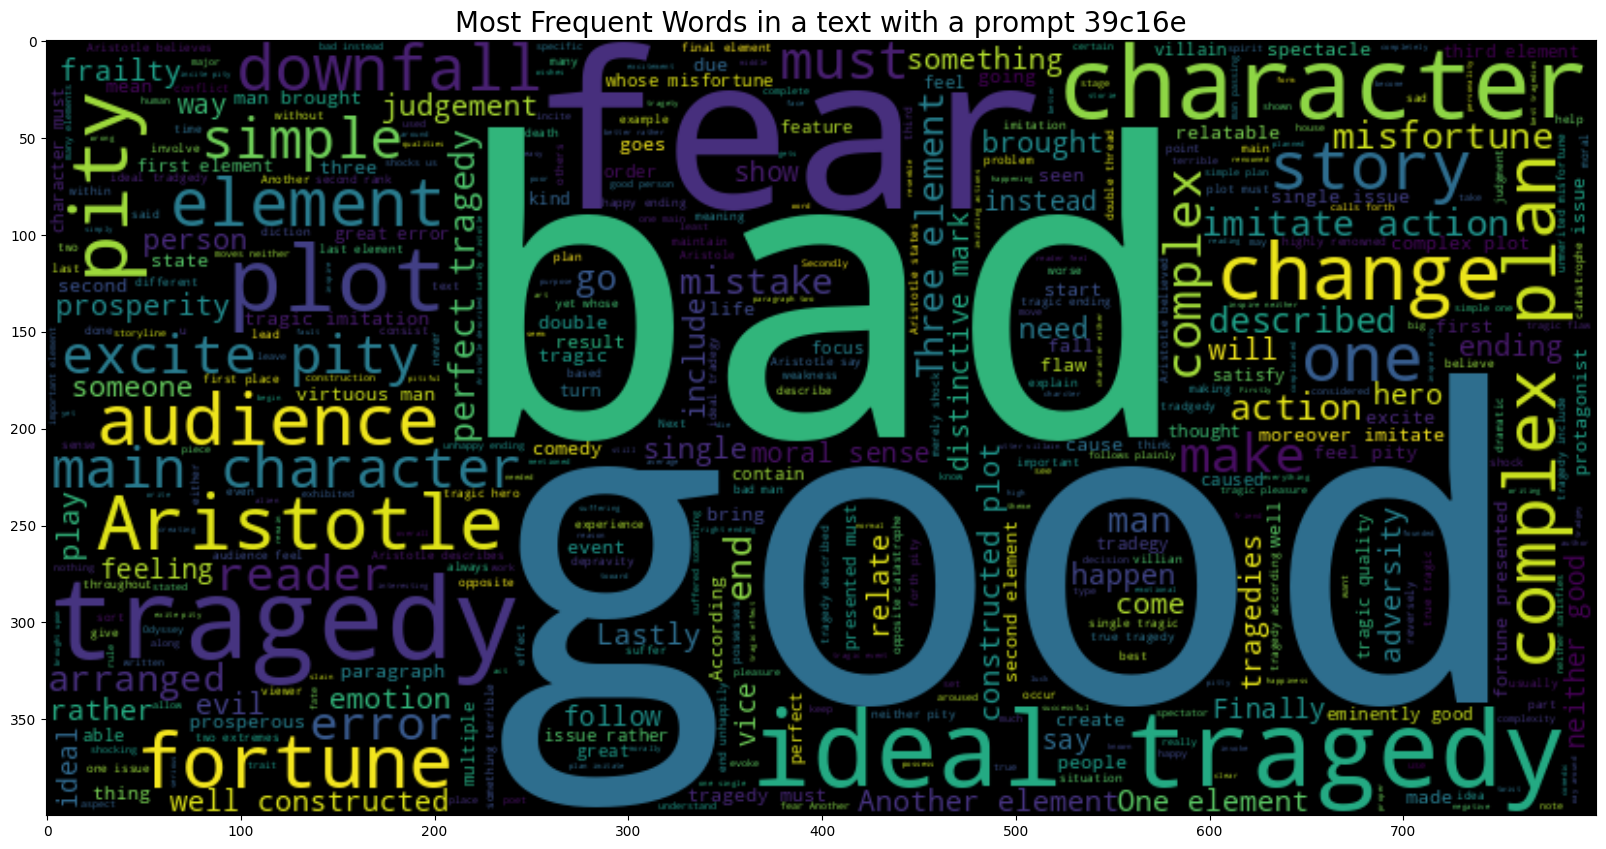

In [103]:
plt.figure(figsize = (20,20))
plt.title("Most Frequent Words in a text with a prompt 39c16e", fontsize = 20)
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(text)
plt.imshow(wc, interpolation = 'bilinear')


## Feature engineering

In [104]:
#Column for the total number of words
df_train_summ["word_count"]=df_train_summ.apply(lambda x: len(x["text"].split(' ')),axis=1)

In [105]:
print("Text: ",df_train_summ.text[1234])
print("Number of words: ",df_train_summ["word_count"][1234])

Text:  they used chemicals to remove the smell of the spoiled meats they also used heat to heat up the insides of the meats to make them not smell anymore and to give the apearence that they are fresh meats.
Number of words:  39


<Axes: xlabel='word_count', ylabel='Count'>

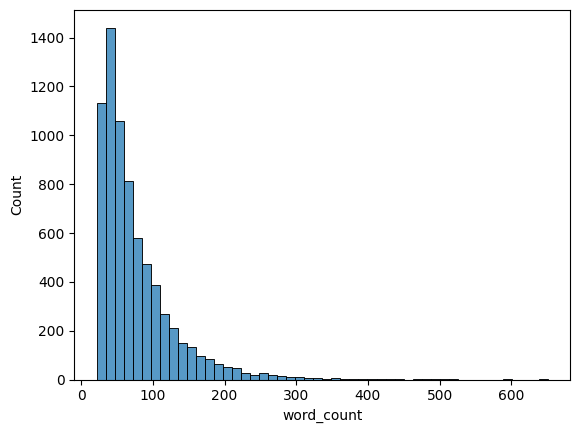

In [106]:
sns.histplot(df_train_summ["word_count"], bins=50)

In [107]:
# Create a scatter plot with marginal histograms for "wording" vs. "word_count"
fig = px.scatter(
    df_train_summ,
    x="word_count",
    y="wording",
    marginal_x="histogram",  # Show histogram on the x-axis
    marginal_y="histogram",  # Show histogram on the y-axis
    labels={"wording": "Wording Point", "word_count": "Word Count"},
    color="prompt_id",
    trendline="ols",
    title="Correlation between Word Count and Wording Score",
)

fig.show()

In the next cell we basically plot the same thing but with an overall regression line

Text(0.5, 1.0, 'correlation between word count and wording score')

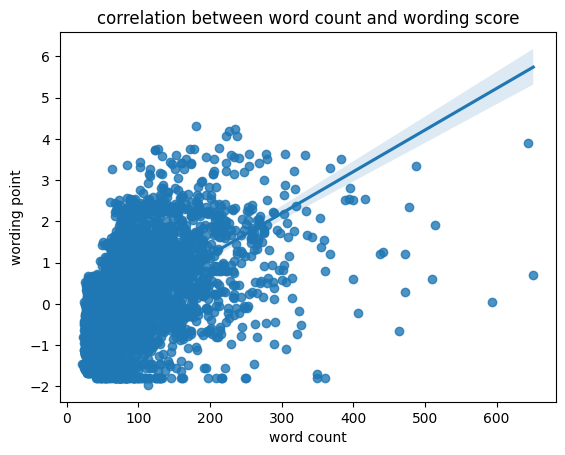

In [108]:
sns.regplot(data=df_train_summ,x="word_count",y="wording", truncate=True)
plt.xlabel("word count")
plt.ylabel("wording point")
plt.title("correlation between word count and wording score")

In [109]:
fig = px.scatter(
    df_train_summ,
    x="word_count",
    y="content",
    marginal_x="histogram",  # Show histogram on the x-axis
    marginal_y="histogram",  # Show histogram on the y-axis
    labels={"content": "Content Point", "word_count": "Word Count"},
    title="Correlation between Word Count and Content Score",
    color="prompt_id",  # Add hue based on "prompt_id"
    trendline="ols"  # Add a linear regression line
)

# Show the plot
fig.show()

In the next cell we basically plot the same thing but with an overall regression line

Text(0.5, 1.0, 'correlation between word count and content score')

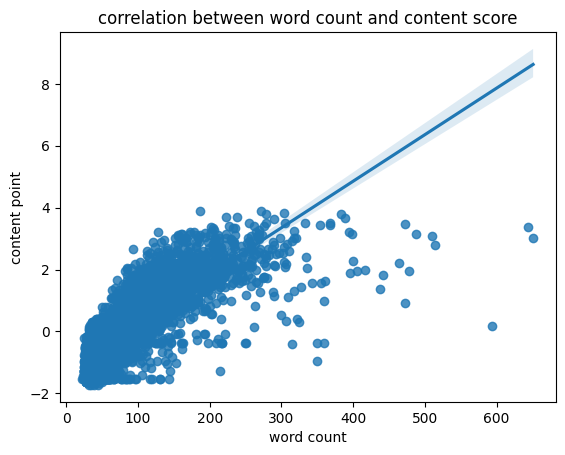

In [110]:
sns.regplot(data=df_train_summ,x="word_count",y="content", truncate=True)
plt.xlabel("word count")
plt.ylabel("content point")
plt.title("correlation between word count and content score")

In [111]:
# Let's do a text transformation

# Convert the text in the "text" column of your DataFrame to lowercase.
df_train_summ["transformed_text"]=df_train_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_train_summ["transformed_text"]=df_train_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

Now, in transformed_text column we have the text in lowercase and without any non-alphanumeric characters (punctuations, other special characters)

In [112]:
print("Transformed Text: ",df_train_summ["transformed_text"][0])

Transformed Text:  the third wave was an experimentto see how people reacted to a new one leader government it gained popularity as people wanted to try new things the students follow anything that is said and start turning on eachother to gain higher power they had to stop the experement as too many people got to radical with it blindly following there leader


## **Modelling**

Now we can start getting ready for modelling

At first lets tokenize the text

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import RobustScaler
import spacy
# ------------------Linear Regression model----------------
from sklearn.linear_model import LinearRegression
# ------------------MSE metric--------------------------------
from sklearn.metrics import mean_squared_error
# we need MSE to get our main metric RMSE

In [ ]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Create an empty list to store tokens
tokens_text = []

# Tokenize each text entry
for text in df_train_summ.transformed_text:
    doc = nlp(text)
    tokens = [token.text for token in doc]
    tokens_text.extend(tokens)


num_unique_words = len(set(tokens_text))
print("Number of unique tokens: ", num_unique_words)

Lets load english stopwords. We will use them in Bag-of-words model which will represent our text as an unordered collection of words. This may be usefull improving the model performance

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
stopwords=nltk.corpus.stopwords
stopwords=stopwords.words('english')

stopwords[:10]

In [ ]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stopwords, #we will use stopwords we defined earlier
    ngram_range=(1, 2) #analysis of two words
)

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from torch.utils.data import Subset

#Train - Test splitting
reviews_train, reviews_test = train_test_split(df_train_summ, test_size=0.2, random_state=42)

In [ ]:
#  The main data well be divided by content and wording to create the two models, also transforming the variables with a robust scaler to improve the performance

sc1=RobustScaler()
sc2=RobustScaler()

#Content model
y_train_cont = sc1.fit_transform(reviews_train[['content']])
y_test_cont = sc1.transform(reviews_test[['content']])

#Wording model
y_train_word = sc2.fit_transform(reviews_train[['wording']])
y_test_word = sc2.transform(reviews_test[['wording']])

In [ ]:
X_train = bow_counts.fit_transform(reviews_train.transformed_text)

X_test = bow_counts.transform(reviews_test.transformed_text)

In [ ]:
# Linear regression for content
cont_model = LinearRegression()
cont_model.fit(X_train, y_train_cont)

In [ ]:
# Linear regression for wording
word_model = LinearRegression()
word_model.fit(X_train, y_train_word)

Lets evaluate our models with RMSE

In [ ]:
test_pred_cont = cont_model.predict(X_test)
print("RMSE for content model: ", np.sqrt(mean_squared_error(y_test_cont, test_pred_cont)))

test_pred_word = word_model.predict(X_test)
print("RMSE for wording model: ", np.sqrt(mean_squared_error(y_test_word, test_pred_word)))

As we did earlier, lets transform the test in the test set

In [ ]:
# Convert the text in the "text" column of your DataFrame to lowercase.
df_test_summ["transformed_text"]=df_test_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_test_summ["transformed_text"]=df_test_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [ ]:
#Transformation of test dataset with train encoding
X_test_final = bow_counts.transform(df_test_summ.transformed_text)

Substituting the predicted values in the sample submission df

In [ ]:
df_samplesub["content"] = sc1.inverse_transform(cont_model.predict(X_test_final))
df_samplesub["wording"] = sc2.inverse_transform(word_model.predict(X_test_final))
df_samplesub

At last, we will save the submission file

In [ ]:
df_samplesub.to_csv("submission.csv",index=False)

Submissions are scored using MCRMSE, mean columnwise root mean squared error:

\begin{equation}
\text{MCRMSE} = \frac{1}{N_t} \sum_{j=1}^{N_t} \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \hat{y}_i - y_i \right)^2}
\end{equation}

where $N_{t}$ is the number of scored ground truth target columns, and ${y}$ and $\hat{y}$ are the actual and predicted values, respectively.



Here is goning to be screenshot of the submission results (or somewhere in the github repo)

# **Practice 2**

HW2 task:

For the CommonLit - Evaluate Student Summaries task and dataset aim to improve compettion score both on validation and leaderboard. Try the following:

improve data processing (text proccessing techniques), feature selection;
tweak vectorization, use both Bag Of Words, TF-IDF (hint: read docs to modify their parameters) and Sentence embeddings (word2vec, SpaCy, BERT Sentence Transformers, etc);
changing model hyperparameters, adding regularization

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

## TF-IDF

We will start with TF-IDF vectorizer

Basically, TF-IDF is a statistical measure of how important a word is to a document in a collection of documents. This will help us find the most important words and will help us improve our model performance

In [ ]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(encoding='utf-8',
                            #  tokenizer=word_tokenize,
                             ngram_range=(1, 1),
                             lowercase=True,
                             stop_words=stopwords,
                             max_features=250)

# Fit the vectorizer to the training data
train_vectorized = pd.DataFrame(
                vectorizer.fit_transform(df_train_summ['transformed_text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

# Fit the vectorizer to the test data
test_vectorized = pd.DataFrame(
                vectorizer.transform(df_test_summ['transformed_text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

In [ ]:
# Copy the training and test data for future use
df_train_summ_copy = df_train_summ.copy()
df_test_summ_copy = df_test_summ.copy()

Now lets concatenate the train and test. This will help us later

In [ ]:
df_train_summ = pd.concat([df_train_summ, train_vectorized], axis=1)
df_test_summ = pd.concat([df_test_summ, test_vectorized], axis=1)

df_train_summ.head()

Now we will get to the feature selection for train data

But before that we should do some preprocessing again for both train and test data. Basically, we will add counters for punctuation, numbers, stopwords; length of the text.

In [ ]:
import string

def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords)
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineering(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [ ]:
df_train_summ = feature_engineering(df_train_summ)
df_test_summ = feature_engineering(df_test_summ)

In [ ]:
df_train_summ.head()

Great. Now we will select the features we will use to train our model

In [ ]:
features = df_train_summ.drop(columns = ['student_id', 'prompt_id', 'text', 'transformed_text', 'word_count', 'content', 'wording'], axis = 1).columns

### Modeling

#### **XGBoost**

In [ ]:
import xgboost as xgb

First of all we will use XGBoost.

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting(a boosting algorithm in machine learning used for classification and regression tasks) framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

[XGBoost docs](https://xgboost.readthedocs.io/en/stable/)

Now let's set the parameters

In [ ]:
N_FOLDS = 10 # Number of folds in the cross-validation
SEED = 42 # Random seed
NUM_ROUNDS = 5000 # Number of rounds (iterations)
EARLY_STOPPING = 500 # Number of rounds with early stopping
VERBOSE = 250 # how much information is printed during the training process. In this case, it prints training information every 250 rounds

In [ ]:
params = {
    'device': 'gpu', # device to use
    'booster': 'gbtree', #  boosting type, which is set to gradient boosted trees
    'objective': 'reg:squarederror', # model aims to minimize the mean squared error.
    'eval_metric': 'rmse', # evaluation metric (root mean squared error)
    'sampling_method': 'uniform', #  which method is used for sampling data points
    'tree_method': 'gpu_hist', #  which method is used for tree construction
    'learning_rate': 0.008, #  learning rate, which basically controls the step size in updating the model during each round
    # 'learning_rate': 0.3, (default value)
    'max_depth': 6, #  maximum depth of a tree
    'subsample': 0.78, #  subsample ratio of the training instances
    'min_child_weight': 5 #  minimum sum of instance weight needed in a child
    # ------------------------------
    # 'learning_rate': 0.048,
    # 'max_depth': 6,
    # 'n_estimators': 10000,
    # 'early_stopping_rounds': 300,
    # 'random_state': 42,
}

'params' is a dictionary contains that various hyperparameters for the XGBoost model:

* 'booster': Specifies the boosting type, which is set to 'gbtree' (gradient boosted trees).

* 'objective': The regression objective is set to 'reg:squarederror', indicating that the model is trained for regression and aims to minimize the mean squared error.

* 'eval_metric': The evaluation metric used during training is 'rmse' (root mean squared error).

* 'sampling_method': The method used for sampling data points. 'uniform' indicates uniform subsampling.

* 'tree_method': The tree construction method is set to 'gpu_hist', indicating that GPU acceleration is used for building trees.

* 'learning_rate': The learning rate controls the step size in updating the model during each round.

* 'max_depth': The maximum depth of the individual decision trees.

* 'subsample': The fraction of samples used for training each tree. It helps prevent overfitting.

* 'min_child_weight': The minimum sum of instance weight (hessian) needed in a child.

In [ ]:
for target in ['content', 'wording']:
    X, y = df_train_summ[features], df_train_summ[target]
    # For each target variable in the loop, create a DataFrame X containing the selected features from the df_train_summ DataFrame and a Series y containing the values of the target variable.

    X_test = df_test_summ[features]
    y_test = np.zeros(shape=df_test_summ.shape[0], dtype=float)
    # For each target variable in the loop, create a DataFrame X_test containing the same selected features from the df_test_summ DataFrame and a Series y_test filled with zeros.

    dmatr_test = xgb.DMatrix(data=X_test)
    # A DMatrix is a specific data structure used by the XGBoost library for efficient model prediction.
    # It allows us to efficiently predict using our trained XGBoost model on the test data.

    cv = KFold(n_splits = N_FOLDS, shuffle = True, random_state = SEED)
    # Define the K-Fold cross-validation, a commonly used technique for assessing a machine learning model's performance.

    # Train loop
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dval = xgb.DMatrix(data=X_val, label=y_val)

        model = xgb.train(params=params,
                          dtrain=dtrain,
                          evals=[(dtrain, 'train'), (dval, 'validation')],
                          num_boost_round=NUM_ROUNDS,
                          early_stopping_rounds=EARLY_STOPPING,
                          verbose_eval=VERBOSE)

        y_test += model.predict(dmatr_test) / N_FOLDS
    df_samplesub[target] = y_test

In [ ]:
df_samplesub

In [ ]:
# In the kaggle notebook we will call the submission file "submission.csv" (because of the submission format),
# but here in this notebook we will call it "submission_XGB.csv" just for the sake of clarity
df_samplesub.to_csv("submission_XGB.csv",index=False)

Here is goning to be screenshot of the submission results (or somewhere in the github repo)

#### **SVR**

SVM regression or Support Vector Regression (SVR) is a machine learning algorithm used for regression analysis. It is different from traditional linear regression methods as it finds a hyperplane that best fits the data points in a continuous space, instead of fitting a line to the data points.
From article: [Support Vector Regression Tutorial for Machine Learning](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# optional line
df_samplesub = pd.read_csv('commonlit_evaluate_student_summaries/sample_submission.csv')

In [ ]:
# List of target variables
target_variables = ['content', 'wording']

# Initialize a list to store RMSE values for each fold
rmse_values = []

# Loop through each target variable
for target in target_variables:
    X, y = df_train_summ[features], df_train_summ[target]
    X_test = df_test_summ[features]
    y_test = np.zeros(shape=df_test_summ.shape[0], dtype=float)

    # Define K-Fold cross-validation
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    # Train loop
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')

        # Initialize and train the SVR model
        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
        model.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_val = model.predict(X_val)

        # Calculate RMSE for the validation set
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        print(f"Validation RMSE: {rmse_val}")

        # Append RMSE to the list
        rmse_values.append(rmse_val)

        # Make predictions on the test data
        y_test += model.predict(X_test) / N_FOLDS

    # Store predictions in the DataFrame
    df_samplesub[target] = y_test

# Calculate the overall Cross-Validation RMSE
overall_cv_rmse = np.mean(rmse_values)
print(f"Overall Cross-Validation RMSE: {overall_cv_rmse:.4f}")

In [ ]:
df_samplesub

In [ ]:
# Same thing as with XGBoost submission
# In the kaggle notebook we will call the submission file "submission.csv" (because of the submission format),
# but here in this notebook we will call it "submission_SVR.csv" just for the sake of clarity
df_samplesub.to_csv("submission_SVR.csv",index=False)

Here is goning to be screenshot of the submission results (or somewhere in the github repo)

Whoah this is better than XGBoost. That was some what of an unexpected result, after all XGBoost is one of the most powerful ML algorithms out there. Fare to say that it's not uncommon for one algorithm to outperform another in certain situations.

Here are several factors that **may** explain why SVR performed better than XGBoost in our case:

1. **Data Characteristics**: SVR may work better when data is simple and linear, while XGBoost excels with complex relationships.

2. **Hyperparameter Settings**: SVR might have better-tuned hyperparameters for our dataset.

3. **Model Complexity**: XGBoost can overfit complex patterns, while SVR provides a simpler model.

4. **Feature Quality**: SVR may handle noisy or irrelevant features better.

5. **Sample Size**: SVR may be more suitable for small datasets.

6. **Metric Choice**: Performance may vary based on the evaluation metric used.


In the end we can use ensembling or combining the predictions from both algorithms to potentially get the best of both worlds.

## Sentence Embeddings

Now let's try to use sentence embeddings to improve our models performance.

In [ ]:
# We'll get the copies of the two datasets
df_train_summ = df_train_summ_copy.copy()
df_test_summ = df_test_summ_copy.copy()

df_train_summ.head()

We'll merge the summary and prompt datasets using the `prompt_id` column.

Basically we are preparing the data for generating the embeddings

In [ ]:
df_train = df_train_prompts.merge(df_train_summ , on = "prompt_id")
df_train.drop(["prompt_id" , "student_id"] , axis = 1 , inplace = True)
df_train["src"]="train"
df_train.head()

In [ ]:
df_test = df_test_prompts.merge(df_test_summ , on = "prompt_id")
df_test["src"]="test"
df_test.head()

In [ ]:
target_cols = ['content', 'wording']

In [ ]:
FOLDS = 20
SEED = 42

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Create a new column 'FOLD' in your DataFrame to store fold numbers
df_train['FOLD'] = np.nan

# Enumerate through the KFold splits and assign fold numbers
for fold_number, (train_index, val_index) in enumerate(kf.split(df_train, df_train[target_cols])):
    df_train.loc[val_index, 'FOLD'] = fold_number

# Display the count of train samples per fold
print('Train samples per fold:')
fold_counts = df_train['FOLD'].value_counts().sort_index()
print(fold_counts)

### Generate Embeddings

In [ ]:
! pip install transformers

In [ ]:
from transformers import AutoModel, AutoTokenizer # will be used to tokenize the text
import torch
import torch.nn.functional as F # contains activation functions like Relu, Sigmoid etc.

In [ ]:
# Define a function to calculate the mean pooling
def mean_pooling(model_output, attention_mask):
    # Create the token embeddings
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [ ]:
# Create a class for the embedded dataset

class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx, "text"] # self.df.loc[idx, "prompt_question"] + self.df.loc[idx, "prompt_title"] + self.df.loc[idx, "prompt_text"] +  self.df.loc[idx,"full_text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

ds_train = EmbedDataset(df_train)
embed_dataloader_tr = torch.utils.data.DataLoader(ds_train,\
                        batch_size=4,\
                        shuffle=False)
ds_test = EmbedDataset(df_test)
embed_dataloader_te = torch.utils.data.DataLoader(ds_test,\
                        batch_size=4,\
                        shuffle=False)

In [ ]:
tokenizer = None
MAX_LEN = 512

def get_embeddings(MODEL_NM='', MAX=640, BATCH_SIZE=4, verbose=True, ex_verbose=False):
    global tokenizer, MAX_LEN
    DEVICE="cuda"
    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX

    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings = sentence_embeddings.squeeze(0).detach().cpu().numpy()
        if ex_verbose:
            print(sentence_embeddings.shape)
        if len(sentence_embeddings.shape) == 1: # janky workaround
            continue
        all_train_text_feats.extend(sentence_embeddings)

    all_train_text_feats = np.array(all_train_text_feats)

    if verbose:
        print('Train embeddings shape', all_train_text_feats.shape)

    te_text_feats = []
    for batch in tqdm(embed_dataloader_te,total=len(embed_dataloader_te)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings = sentence_embeddings.squeeze(0).detach().cpu().numpy()
        te_text_feats.extend(sentence_embeddings)
    te_text_feats = np.array(te_text_feats)
    if verbose:
        print('Test embeddings shape',te_text_feats.shape)

    return all_train_text_feats, te_text_feats

In [ ]:
# Download DeBERTa v3 large model from kaggle
! kaggle datasets download -d hiromoon166/deberta-v3-large

In [ ]:
model = 'deberta-v3-large/deberta-v3-large'
all_train_text_embs, te_text_embs = get_embeddings(model, MAX=512)

In [ ]:
print('Our embeddings have shape', all_train_text_embs.shape )

### Train an SVR

We'll stick with the SVR model for now

In [ ]:
# The metric
from sklearn.metrics import mean_squared_error

preds = []
scores = []

def comp_score(y_true, y_pred):
    rmse_scores = []
    for i in range(len(target_cols)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i], y_pred[:,i])))
    return np.mean(rmse_scores)

In [ ]:
test_preds = np.zeros((len(te_text_embs),2))

In [ ]:
df_train.drop(df_train.index[-1], inplace=True)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, df_train[target_cols])):
    print(f"| Fold {fold+1} |".center(80, "-"))

    # Split the data into train and validation sets
    df_train_set = df_train.iloc[train_idx]
    df_eval_set = df_train.iloc[val_idx]


    tr_text_embs = all_train_text_embs[train_idx, :]
    ev_text_embs = all_train_text_embs[val_idx, :]

    ev_preds = np.zeros((len(val_idx), len(target_cols)))
    test_preds = np.zeros((len(te_text_embs), len(target_cols)))

    for i, t in enumerate(target_cols):
        print(t, ', ', end='')
        clf = SVR(C=1.0, epsilon=0.1, kernel='rbf')
        clf.fit(tr_text_embs, df_train_set[t].values)
        ev_preds[:, i] = clf.predict(ev_text_embs)
        test_preds[:, i] = clf.predict(te_text_embs)

    print()

    # Calculate RMSE for this fold
    score = np.sqrt(mean_squared_error(df_eval_set[target_cols].values, ev_preds))
    scores.append(score)
    print(f"Fold {fold+1} RMSE score: {score}")

    preds.append(test_preds)

# Calculate overall CV RMSE
overall_score = np.mean(scores)
print(f'Overall CV RMSE = {overall_score}')

In [ ]:
sub = df_test.copy()
sub.loc[:,target_cols] = np.array(test_preds)
sub_columns = df_samplesub.columns
sub = sub[sub_columns]

In [ ]:
sub.to_csv("submission.csv",index=None)

Here is goning to be screenshot of the submission results (or somewhere in the github repo)